# Importing Libraries

In [19]:
import os
import mne
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif,f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.signal import medfilt, savgol_filter
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from mne.time_frequency import psd_array_welch
from scipy.stats import skew, kurtosis,entropy
import nolds
import re
import antropy as ant
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.dummy import DummyClassifier
from sklearn.manifold import TSNE

# Loading Dataset

In [20]:
data_dir = './ds006036/' 
subjects = sorted([d for d in os.listdir(data_dir) if d.startswith('sub-')])

In [21]:
participants_path = os.path.join(data_dir, 'participants.tsv')
if os.path.exists(participants_path):
    participants = pd.read_csv(participants_path, sep='\t')
    print(participants.head(20))
    print(participants.columns)
else:
    print("No participants.tsv file found.")

   participant_id Gender  Age Group  MMSE  
0         sub-001      F   57     A      16
1         sub-002      F   78     A      22
2         sub-003      M   70     A      14
3         sub-004      F   67     A      20
4         sub-005      M   70     A      22
5         sub-006      F   61     A      14
6         sub-007      F   79     A      20
7         sub-008      M   62     A      16
8         sub-009      F   77     A      23
9         sub-010      M   69     A      20
10        sub-011      M   71     A      22
11        sub-012      M   63     A      18
12        sub-013      F   64     A      20
13        sub-014      M   77     A      14
14        sub-015      M   61     A      18
15        sub-016      F   68     A      14
16        sub-017      F   61     A       6
17        sub-018      F   73     A      23
18        sub-019      F   62     A      14
19        sub-020      M   71     A       4
Index(['participant_id', 'Gender', 'Age', 'Group', 'MMSE  '], dtype='object'

In [22]:
print(participants['Group'].unique())

['A' 'C' 'F']


- Seeing that there is dignostic provided in the participant file for  Alzheimer’s Disease (AD), Frontotemporal Dementia (FTD), Healthy Subjects (HS)
- It is possible to link waveforms for each eeg signals to their respective MMSE(Min Mental State Examination).

In [23]:
X_all = []
mmse_scores = []
epochs_list = [] 
valid_subjects = []
participant_info = pd.read_csv('./ds006036/participants.tsv', sep='\t')
participant_info.columns = participant_info.columns.str.strip()  # Cleaning  column names


In [24]:
participant_info['MMSE'] = pd.to_numeric(participant_info['MMSE'], errors='coerce')

# Preprocessing of Signals

In [25]:
from mne.preprocessing import ICA
from scipy.stats import kurtosis

for subj in subjects:
    subj_path = os.path.join(data_dir, subj, 'eeg')
    eeg_file = next((f for f in os.listdir(subj_path) if f.endswith('.set')), None)
    event_file = next((f for f in os.listdir(subj_path) if f.endswith('_events.tsv')), None)

    if not eeg_file or not event_file:
        print(f"Skipping {subj}: Missing EEG or events file.")
        continue

    try:
        raw_data = mne.io.read_raw_eeglab(os.path.join(subj_path, eeg_file), preload=True)
        raw_data._data *= 1e6  # Convert to microvolts

        # Filtering: median and Savitzky-Golay
        raw_data._data = np.array([medfilt(ch, kernel_size=5) for ch in raw_data._data])
        raw_data._data = np.array([savgol_filter(ch, window_length=11, polyorder=2) for ch in raw_data._data])

        # Bandpass and notch filters
        raw_data.filter(l_freq=0.5, h_freq=45.0)
        raw_data.notch_filter(freqs=[50.0, 100.0], fir_design='firwin')

        # Resample to 100Hz
        raw_data.resample(100)

        # Average reference and z-score normalization
        raw_data.set_eeg_reference('average', projection=False)
        data = raw_data.get_data()
        raw_data._data = (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

        # === ICA Artifact Removal ===
        ica = ICA(n_components=0.999, random_state=42, max_iter='auto')
        ica.fit(raw_data)
        try:
            eog_inds, _ = ica.find_bads_eog(raw_data)
            ica.exclude = eog_inds
        except Exception:
            scores = ica.get_sources(raw_data).get_data()
            kurt = np.apply_along_axis(kurtosis, 1, np.abs(scores))
            ica.exclude = np.where(kurt > 10)[0].tolist()
        ica.apply(raw_data)

        # === Event File Parsing ===
        event_df = pd.read_csv(os.path.join(subj_path, event_file), sep='\t')

        def safe_parse(label):
            match = re.search(r'photo\s*(\d+)\s*hz', str(label).lower())
            return int(match.group(1)) if match else None

        event_array = []
        for _, row in event_df.iterrows():
            label = safe_parse(row['value'])
            if label is not None:
                sample = int(float(row['sample']))
                event_array.append([sample, 0, label])

        event_array = np.array(event_array)
        sfreq = raw_data.info['sfreq']
        max_epoch_end = raw_data.n_times / sfreq - 1.0
        valid_event_array = event_array[event_array[:, 0] / sfreq <= max_epoch_end]

        if len(valid_event_array) == 0:
            print(f"{subj} | No valid events within duration.")
            continue

        # === Epoching ===
        epochs = mne.Epochs(raw_data, events=valid_event_array, event_id=None,
                            tmin=-0.2, tmax=1.0, baseline=(-0.2, 0.0), preload=True)
        if len(epochs) == 0:
            print(f"{subj} | All epochs dropped.")
            continue

        # Skip epochs with non-19 channels
        valid_epoch_indices = [i for i, ep in enumerate(epochs.get_data()) if ep.shape[0] == 19]
        if not valid_epoch_indices:
            print(f"{subj} | All epochs missing channels.")
            continue
        epochs = epochs[valid_epoch_indices]

        # === MMSE Score Handling ===
        mmse_row = participant_info[participant_info['participant_id'] == subj]
        if mmse_row.empty or pd.isnull(mmse_row['MMSE'].values[0]):
            print(f"{subj} | MMSE missing or invalid.")
            continue

        mmse_score = int(mmse_row['MMSE'].values[0])

        # === Final Aggregation ===
        X_all.append(epochs.get_data())
        mmse_scores.append(np.full(len(epochs), mmse_score))
        epochs_list.append(epochs)
        valid_subjects.append(subj)

    except Exception as e:
        print(f"Error processing {subj}: {e}")
        continue


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 8 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 17 ICA components
    Projecting back using 19 PCA components
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 14 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 13 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 13 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 12 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 12 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 11 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 13 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 14 ICA components
    Projecting back using 19 PCA components
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 16 ICA components
    Projecting back using 19 PCA components
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 14 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 12 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 17 ICA components
    Projecting back using 19 PCA components
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 7 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 9 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 7 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 15 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 14 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 8 ICA components
    Projecting back using 19 PCA components
sub-029 | No valid events within duration.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) m

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 11 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Sett

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 8 ICA components
    Projecting back using 19 PCA components
sub-033 | No valid events within duration.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) m

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 17 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 9 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 9 ICA components
    Projecting back using 19 PCA components
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 8 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 16 ICA components
    Projecting back using 19 PCA components
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 15 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 13 ICA components
    Projecting back using 19 PCA components
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 1.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.9s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 8 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 7 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 14 ICA components
    Projecting back using 19 PCA components
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 13 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 15 ICA components
    Projecting back using 19 PCA components
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 11 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 1.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 3 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 10 ICA components
    Projecting back using 19 PCA components
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 9 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 7 ICA components
    Projecting back using 19 PCA components
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 1.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 10 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 1.1s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 10 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by explained variance: 16 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 16 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 1.0s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 11 ICA components
    Projecting back using 19 PCA components
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 10 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 9 ICA components
    Projecting back using 19 PCA components
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 12 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 10 ICA components
    Projecting back using 19 PCA components
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 10 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 13 ICA components
    Projecting back using 19 PCA components
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 13 ICA components
    Projecting back using 19 PCA components
Not setting metadata
6 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 11 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 3 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 10 ICA components
    Projecting back using 19 PCA components
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
sub-081 | No valid events within duration.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) m

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 8 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 7 ICA components
    Projecting back using 19 PCA components
sub-085 | No valid events within duration.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) m

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 4 ICA components
    Projecting back using 19 PCA components
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 121 original time points ...
0 bad epochs dropped
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 18 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components
sub-088 | No valid events within duration.


In [26]:
print(f"Processed {len(valid_subjects)} subjects.")
print(f"Final X_all shape: {np.concatenate(X_all).shape}")
print(f"Final MMSE shape: {np.concatenate(mmse_scores).shape}")

Processed 83 subjects.
Final X_all shape: (262, 19, 121)
Final MMSE shape: (262,)


In [27]:
 X_all = np.concatenate(X_all, axis=0) # Labeling data and combining with MMSE
mmse_scores = np.concatenate(mmse_scores)


In [28]:
diagnosis_map = {'A': 'AD', 'F': 'FTD', 'C': 'CN'} #preparing labels
y_diagnosis = []
for subj, epochs in zip(valid_subjects, epochs_list):
    row = participant_info[participant_info['participant_id'] == subj]
    if not row.empty:
        label = row['Group'].values[0].strip()
        y_diagnosis.extend([diagnosis_map[label]] * len(epochs))

# Feature Extraction

## Frequency Domain Feature Extraction

In [29]:
def extract_bandpower_features(epochs_list, sfreq=100.0, bands=None):
    if bands is None:
        bands = [
            (0.5, 4),    # Delta
            (4, 8),    # Theta
            (8, 13),   # Alpha
            (13, 25),  # Beta
            (25, 45)   # Gamma
        ]

    features = []

    for epochs in epochs_list:
        n_times = epochs.get_data().shape[2]
        safe_n_fft = min(100, n_times)

        # Compute PSD and frequencies
        psd = epochs.compute_psd(method='welch', fmin=1, fmax=45, n_fft=safe_n_fft, verbose='ERROR')
        psds, freqs = psd.get_data(return_freqs=True)  # shape: (n_epochs, n_channels, n_freqs)

        for epoch_psd in psds:  # shape: (n_channels, n_freqs)
            epoch_feat = []
            for fmin, fmax in bands:
                idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
                band_powers = epoch_psd[:, idx_band].mean(axis=1) if np.any(idx_band) else np.zeros(epoch_psd.shape[0])
                epoch_feat.extend(band_powers)
            features.append(epoch_feat)

    return np.array(features)


In [30]:
frequency_features = extract_bandpower_features(epochs_list, sfreq=100.0)

In [31]:
frequency_features.shape

(262, 95)

In [32]:
def extract_relative_bandpower_features(epochs_list, sfreq=100.0, bands=None):
    abs_power = extract_bandpower_features(epochs_list, sfreq=sfreq, bands=bands)
    
    # Reshape: (n_epochs, n_channels, n_bands)
    n_epochs = abs_power.shape[0]
    n_bands = len(bands if bands else [(0.5, 4), (4, 8), (8, 13), (13, 25), (25, 45)])
    n_channels = abs_power.shape[1] // n_bands
    
    abs_power_reshaped = abs_power.reshape(n_epochs, n_channels, n_bands)

    # Compute relative power
    total_power = np.sum(abs_power_reshaped, axis=2, keepdims=True)  # total across bands
    rel_power = abs_power_reshaped / (total_power + 1e-10)  # avoid division by zero

    return rel_power.reshape(n_epochs, -1)  # flatten back to 2D


In [33]:
relative_band_features = extract_relative_bandpower_features(epochs_list)


In [34]:
relative_band_features.shape

(262, 95)

In [35]:
def extract_spectral_entropy_features(epochs_list, sfreq=100):
    features = []

    for epochs in epochs_list:
        n_times = epochs.get_data().shape[2]
        safe_n_fft = min(100, n_times)

        psd = epochs.compute_psd(method='welch', fmin=1, fmax=45, n_fft=safe_n_fft, verbose='ERROR')
        psds, freqs = psd.get_data(return_freqs=True)  # (n_epochs, n_channels, n_freqs)

        subj_feats = []
        for epoch_psd in psds:
            epoch_feat = []
            for ch_psd in epoch_psd:
                psd_sum = np.sum(ch_psd)
                if psd_sum == 0:
                    psd_norm = np.ones_like(ch_psd) / len(ch_psd)
                else:
                    psd_norm = ch_psd / psd_sum
                spectral_ent = entropy(psd_norm)
                epoch_feat.append(spectral_ent)
            subj_feats.append(epoch_feat)
        features.append(np.array(subj_feats))

    return np.vstack(features)

In [36]:
spectral_entropy_features = extract_spectral_entropy_features(epochs_list)

In [37]:
spectral_entropy_features.shape

(262, 19)

In [38]:
print("Has NaN:", np.isnan(spectral_entropy_features).any())
print("Has +inf:", np.isposinf(spectral_entropy_features).any())
print("Has -inf:", np.isneginf(spectral_entropy_features).any())

Has NaN: False
Has +inf: False
Has -inf: False


## Time Domain Feature Extraction

In [39]:
def extract_time_domain_features(epochs_list):
    features = []

    for epochs in epochs_list:
        data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)

        subj_feats = []
        for epoch in data:
            epoch_feats = []
            for ch_data in epoch:
                skew_val = skew(ch_data)
                kurt_val = kurtosis(ch_data)
                ptp_val = np.ptp(ch_data)
                epoch_feats.extend([skew_val, kurt_val,ptp_val])
            subj_feats.append(epoch_feats)

        features.append(np.array(subj_feats))

    return np.vstack(features)

In [40]:
time_features = extract_time_domain_features(epochs_list)

In [41]:
time_features.shape

(262, 57)

In [42]:
def extract_sample_entropy_features(epochs_list):
    features = []

    for epochs in epochs_list:
        data = epochs.get_data()
        subj_feats = []
        for epoch in data:
            epoch_feat = []
            for ch_data in epoch:
                try:
                    samp_ent = ant.sample_entropy(ch_data)
                    if not np.isfinite(samp_ent):
                        samp_ent = 0.0  # fallback for NaN or inf
                except Exception:
                    samp_ent = 0.0
                epoch_feat.append(samp_ent)
            subj_feats.append(epoch_feat)
        features.append(np.array(subj_feats))

    return np.vstack(features)


In [43]:
sample_entropy_features = extract_sample_entropy_features(epochs_list)

In [44]:
sample_entropy_features.shape

(262, 19)

In [45]:
print("Has NaN:", np.isnan(sample_entropy_features).any())
print("Has +inf:", np.isposinf(sample_entropy_features).any())
print("Has -inf:", np.isneginf(sample_entropy_features).any())

Has NaN: False
Has +inf: False
Has -inf: False


In [46]:
def extract_hjorth_parameters(epochs_list):
    def hjorth_params(signal):
        first_deriv = np.diff(signal)
        second_deriv = np.diff(first_deriv)

        var_zero = np.var(signal)
        var_d1 = np.var(first_deriv)
        var_d2 = np.var(second_deriv)

        mobility = np.sqrt(var_d1 / var_zero) if var_zero > 0 else 0
        complexity = np.sqrt(var_d2 / var_d1) if var_d1 > 0 else 0

        return mobility, complexity

    features = []

    for epochs in epochs_list:
        data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
        subj_feats = []
        for epoch in data:
            epoch_feat = []
            for ch_data in epoch:
                mob, comp = hjorth_params(ch_data)
                epoch_feat.extend([mob, comp])
            subj_feats.append(epoch_feat)
        features.append(np.array(subj_feats))

    return np.vstack(features)


In [47]:
hjorth_features = extract_hjorth_parameters(epochs_list)

In [48]:
hjorth_features.shape

(262, 38)

In [49]:
def extract_fractal_features(epochs_list):
    features = []
    for epochs in epochs_list:
        data = epochs.get_data()
        subj_feats = []
        for epoch in data:
            epoch_feats = []
            for ch_data in epoch:
                try:
                    petrosian_fd = nolds.petrosian_fd(ch_data)
                    higuchi_fd = nolds.higuchi_fd(ch_data)
                except:
                    petrosian_fd = higuchi_fd = 0
                epoch_feats.extend([petrosian_fd, higuchi_fd])
            subj_feats.append(epoch_feats)
        features.append(np.array(subj_feats))
    return np.vstack(features)


In [50]:
fractial_dimension=extract_fractal_features(epochs_list)

In [51]:
fractial_dimension.shape

(262, 38)

In [52]:
def extract_zero_crossing_rate(epochs_list):
    features = []
    for epochs in epochs_list:
        data = epochs.get_data()
        subj_feats = []
        for epoch in data:
            epoch_feats = []
            for ch_data in epoch:
                zcr = ((ch_data[:-1] * ch_data[1:]) < 0).sum()
                epoch_feats.append(zcr)
            subj_feats.append(epoch_feats)
        features.append(np.array(subj_feats))
    return np.vstack(features)


In [53]:
zcr_features=extract_zero_crossing_rate(epochs_list)

In [54]:
zcr_features.shape

(262, 19)

In [55]:
def extract_ssc(epochs_list):
    features = []
    for epochs in epochs_list:
        data = epochs.get_data()
        subj_feats = []
        for epoch in data:
            epoch_feats = []
            for ch_data in epoch:
                ssc = np.sum(np.diff(np.sign(np.diff(ch_data))) != 0)
                epoch_feats.append(ssc)
            subj_feats.append(epoch_feats)
        features.append(np.array(subj_feats))
    return np.vstack(features)

In [56]:
ssc_features=extract_ssc(epochs_list)

In [57]:
ssc_features.shape

(262, 19)

## DFA (Detrended Fluctuation Analysis)

In [58]:
def extract_dfa_features(epochs_list):
    features = []
    for epochs in epochs_list:
        subject_feats = []
        for epoch in epochs.get_data():  # shape: (n_channels, n_times)
            epoch_feats = []
            for ch_data in epoch:
                try:
                    # DFA returns a single value per signal
                    dfa_val = nolds.dfa(ch_data)
                    epoch_feats.append(dfa_val)
                except Exception as e:
                    print(f"Error in DFA: {e}")
                    epoch_feats.append(np.nan)
            subject_feats.append(epoch_feats)
        features.append(np.array(subject_feats))
    return np.vstack(features)


In [59]:
dfa_features=extract_dfa_features(epochs_list)

In [60]:
dfa_features.shape

(262, 19)

In [61]:
if np.isnan(dfa_features).any():
    print("DFA feature matrix contains NaN values!")
    
    # Optional: Show how many and where
    nan_count = np.isnan(dfa_features).sum()
    print(f"Total NaNs: {nan_count}")

    # Find row indices with NaNs
    rows_with_nan = np.where(np.isnan(dfa_features).any(axis=1))[0]
    print(f"Rows with NaNs: {rows_with_nan}")
else:
    print("No NaN values found in DFA features.")

No NaN values found in DFA features.


## Discrete Wavelets Transformation

In [62]:
def extract_wavelet_features(epochs_list, wavelet='db4', level=4):
    features = []

    for epochs in epochs_list:
        data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)

        subj_feats = []
        for epoch in data:
            epoch_feats = []
            for ch_data in epoch:
                coeffs = pywt.wavedec(ch_data, wavelet, level=level)
                for c in coeffs:
                    energy = np.sum(c**2)
                    entropy = -np.sum((c**2) * np.log(c**2 + 1e-10))  # entropy of energy
                    epoch_feats.extend([energy, entropy])
            subj_feats.append(epoch_feats)

        features.append(np.array(subj_feats))

    return np.vstack(features)

In [63]:
x_wavelet = extract_wavelet_features(epochs_list)

In [64]:
x_wavelet.shape

(262, 190)

In [65]:
def get_max_level(signal_len, wavelet_name='db4'):
    wavelet = pywt.Wavelet(wavelet_name)
    return pywt.dwt_max_level(signal_len, wavelet.dec_len)

In [66]:
n_times = epochs_list[0].get_data().shape[2]  # Get signal length
max_level = get_max_level(n_times)
print(f"Maximum safe level: {max_level}")

Maximum safe level: 4


# Training and Test Data set

In [67]:
le = LabelEncoder()
y = le.fit_transform(y_diagnosis)  # y_diagnosis: ['AD', 'FTD', 'HS', ...]
print(le.classes_)  

['AD' 'CN' 'FTD']


In [68]:
print("Class mapping:", list(le.classes_))
print("Encoded labels:", np.unique(y))

Class mapping: ['AD', 'CN', 'FTD']
Encoded labels: [0 1 2]


In [69]:
from collections import Counter
print(Counter(y))

Counter({1: 104, 0: 100, 2: 58})


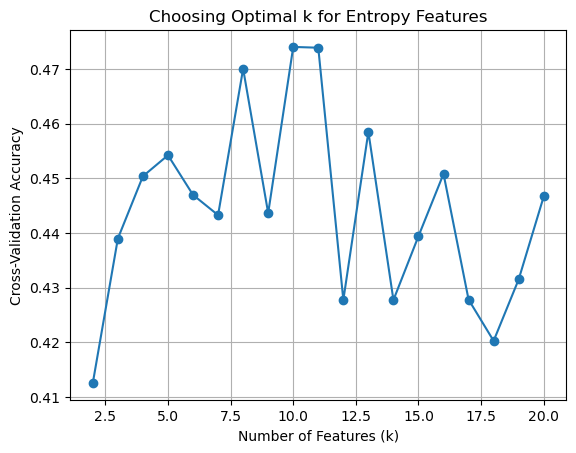

In [70]:
entropy_features = np.hstack([spectral_entropy_features, sample_entropy_features])
k_values = list(range(2, min(entropy_features.shape[1], 20) + 1))  # e.g., try k from 2 to 20
scores = []
for k in k_values:
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    
    # Build a pipeline: feature selection + classifier
    pipeline = Pipeline([
        ('select', selector),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    
    # Evaluate using cross-validation
    cv_scores = cross_val_score(pipeline, entropy_features, y, cv=5, scoring='accuracy')
    scores.append(cv_scores.mean())

# Plot accuracy vs. k
plt.plot(k_values, scores, marker='o')
plt.xlabel("Number of Features (k)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Choosing Optimal k for Entropy Features")
plt.grid(True)
plt.show()

In [71]:
best_k = k_values[np.argmax(scores)]
print(f"Best k: {best_k} with accuracy: {max(scores):.4f}")

Best k: 10 with accuracy: 0.4740


In [72]:
# Combining features
entropy_features = np.hstack([spectral_entropy_features, sample_entropy_features])
selector = SelectKBest(score_func=mutual_info_classif, k=10)  # Select top 19 features
entropy_selected = selector.fit_transform(entropy_features, y)
X = np.hstack([frequency_features, time_features, dfa_features,entropy_selected,hjorth_features,x_wavelet,zcr_features,ssc_features,fractial_dimension,relative_band_features]) # <= X

In [74]:
print(f" X shape: {X.shape}")
print(f" y shape: {y.shape}")

 X shape: (262, 580)
 y shape: (262,)


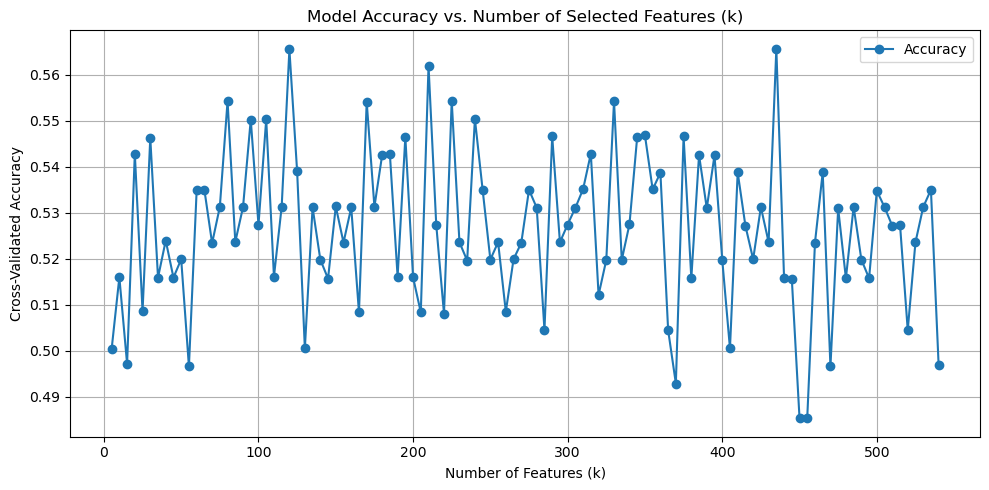

✅ Best k: 435, Accuracy: 0.5656


In [75]:
# Step 1: Remove constant (zero-variance) features
vt = VarianceThreshold(threshold=0.0)
X_filtered = vt.fit_transform(X)  # X is your full feature matrix

# Step 2: Scale the features (optional but good for consistency across classifiers)
scaler = StandardScaler()
X_filtered = scaler.fit_transform(X_filtered)

# Step 3: Select best k using cross-validation
k_values = list(range(5, X_filtered.shape[1] + 1, 5))  # Try every 5 features up to total

scores = []
for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline([
        ('feature_selection', selector),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    cv_score = cross_val_score(pipeline, X_filtered, y, cv=5, scoring='accuracy').mean()
    scores.append(cv_score)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(k_values, scores, marker='o', label="Accuracy")
plt.title("Model Accuracy vs. Number of Selected Features (k)")
plt.xlabel("Number of Features (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Report best k
best_k = k_values[np.argmax(scores)]
print(f"✅ Best k: {best_k}, Accuracy: {max(scores):.4f}")

In [76]:
# Apply ANOVA F-test to select top k features
selector = SelectKBest(score_func=f_classif, k=435)  # adjust k
X_selected = selector.fit_transform(X, y)


/home/shamed/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464
 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482
 483 484] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/shamed/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


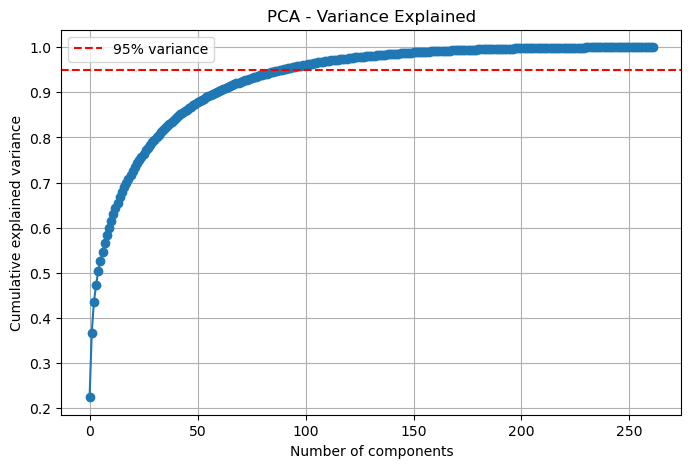

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
# Assuming X_scaled is your standardized data
pca = PCA().fit(X_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()
plt.title('PCA - Variance Explained')
plt.show()


In [78]:
# Spliting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)
print(f" X Training set shape: {X_train.shape}")
print(f"X Test set shape: {X_test.shape}")
print("y Training Shape:",y_train.shape, "y Test set Shape:",y_test.shape)
print(np.unique(y_train), np.unique(y_test))

 X Training set shape: (183, 435)
X Test set shape: (79, 435)
y Training Shape: (183,) y Test set Shape: (79,)
[0 1 2] [0 1 2]


In [79]:
print("Train labels:", np.unique(y_train))
print("Test labels:", np.unique(y_test))

Train labels: [0 1 2]
Test labels: [0 1 2]


In [80]:
print(np.any(np.isnan(X_train)), np.any(np.isnan(X_test)))
print(np.any(np.isnan(y_train)), np.any(np.isnan(y_test)))

False False
False False


In [81]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print("Baseline Accuracy:", dummy.score(X_test, y_test))


Baseline Accuracy: 0.3924050632911392


In [82]:
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))

RF Accuracy: 0.6962025316455697


In [83]:
# Flatten and convert to int
y_train1 = y_train.ravel().astype(int)
y_test1 = y_test.ravel().astype(int) 
from sklearn.decomposition import PCA

# First, standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Apply PCA (e.g., retain 95% of variance)
pca = PCA(n_components=90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = xgb.XGBClassifier(
    objective='multi:softprob',  # Soft probabilities for multi-class
    num_class=3,                 # AD, FTD, HS
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    max_depth=8,
    learning_rate=0.1,
    n_estimators=200
)

model.fit(X_train_pca, y_train1)

# Predict
y_pred = model.predict(X_test_pca)

/home/shamed/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:56:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [84]:
print("Accuracy:", accuracy_score(y_test1, y_pred))
print("Classification Report:\n", classification_report(y_test1, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test1, y_pred))

Accuracy: 0.6962025316455697
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70        30
           1       0.67      0.71      0.69        31
           2       0.75      0.67      0.71        18

    accuracy                           0.70        79
   macro avg       0.71      0.69      0.70        79
weighted avg       0.70      0.70      0.70        79

Confusion Matrix:
 [[21  7  2]
 [ 7 22  2]
 [ 2  4 12]]


In [85]:
print("Shape:", y_train1.shape)
print("Unique labels:", np.unique(y_train1))
print("Type:", type(y_train1), y_train1.dtype)

Shape: (183,)
Unique labels: [0 1 2]
Type: <class 'numpy.ndarray'> int64


In [86]:
# If labels already one-hot encoded — no need to call to_categorical
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Apply PCA (e.g., retain 95% of variance)
pca = PCA(n_components=90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Define a simple feedforward neural network

mlp_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_pca.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
# Train the model
history = mlp_model.fit(X_train_pca, y_train_cat,
                        validation_data=(X_test_pca, y_test_cat),
                        epochs=100,
                        batch_size=32,
                        callbacks=[early_stop],
                        verbose=1)

# Evaluate the model
test_loss, test_acc = mlp_model.evaluate(X_test_pca, y_test_cat, verbose=0)
print(f"MLP Accuracy: {test_acc:.4f}")

Epoch 1/100


/home/shamed/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-24 15:56:51.122987: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.3465 - loss: 1.7857 - val_accuracy: 0.4177 - val_loss: 1.2593
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4064 - loss: 1.3675 - val_accuracy: 0.5190 - val_loss: 1.0970
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6428 - loss: 0.8505 - val_accuracy: 0.5823 - val_loss: 1.0410
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6316 - loss: 0.9198 - val_accuracy: 0.6076 - val_loss: 1.0107
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7029 - loss: 0.6824 - val_accuracy: 0.6076 - val_loss: 0.9865
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7056 - loss: 0.7364 - val_accuracy: 0.6329 - val_loss: 0.9518
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7180 - loss: 0.6643 - val_accuracy: 0.6329 - val_loss: 0.9226
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7750 - loss: 0.5045 - val_accuracy: 0.6456 - val_loss: 0.9004
Epoc

In [87]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# MLP Classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42,
    learning_rate_init=0.001
)

# Fit model
mlp.fit(X_train_pca, y_train)

# Predict
y_pred = mlp.predict(X_test_pca)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.7215189873417721
Classification Report:
               precision    recall  f1-score   support

          AD       0.73      0.63      0.68        30
          CN       0.75      0.77      0.76        31
         FTD       0.67      0.78      0.72        18

    accuracy                           0.72        79
   macro avg       0.72      0.73      0.72        79
weighted avg       0.72      0.72      0.72        79



## Multi Model Classification

In [88]:
# Define models
rf = RandomForestClassifier(n_estimators=200,random_state=42)
mlp = MLPClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Create voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('mlp', mlp), ('xgb', xgb)],
    voting='soft'  # use 'soft' for probabilities, 'hard' for class labels
)

# Train
voting_clf.fit(X_train, y_train)

# Predict
y_pred_mmdl = voting_clf.predict(X_test)


/home/shamed/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shamed/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:57:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [89]:
print("RF Accuracy:", accuracy_score(y_test, y_pred_mmdl))

RF Accuracy: 0.7468354430379747


In [90]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=90)  # Adjust based on variance
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)
# Define and train TensorFlow neural network
def create_mlp():
    model = Sequential([
    Dense(256, activation='relu', input_shape=(90,)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax')
])
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

mlp = create_mlp()
mlp.fit(X_train_scaled, y_train, epochs=60, batch_size=32, verbose=1)
mlp_prob = mlp.predict(X_train_scaled, verbose=0)  # Probabilities for meta-learner
mlp_prob_test = mlp.predict(X_test_scaled, verbose=0)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_prob = rf_model.predict_proba(X_train_scaled)
rf_prob_test = rf_model.predict_proba(X_test_scaled)

# Train XGBoost
xgb_model = XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train_scaled, y_train)
xgb_prob = xgb_model.predict_proba(X_train_scaled)
xgb_prob_test = xgb_model.predict_proba(X_test_scaled)

# Combine predictions for meta-learner
meta_X_train = np.hstack([mlp_prob, rf_prob, xgb_prob])
meta_X_test = np.hstack([mlp_prob_test, rf_prob_test, xgb_prob_test])

# Train meta-learner
meta_learner = LogisticRegression()
meta_learner.fit(meta_X_train, y_train)
final_pred = meta_learner.predict(meta_X_test)
print(f"Test Accuracy: {accuracy_score(y_test, final_pred):.4f}")

Epoch 1/60


/home/shamed/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4111 - loss: 1.5199
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4871 - loss: 1.2870 
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5923 - loss: 0.9570 
Epoch 4/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6389 - loss: 0.9546  
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6711 - loss: 0.7742 
Epoch 6/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6926 - loss: 0.6771 
Epoch 7/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7700 - loss: 0.5685 
Epoch 8/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7179 - loss: 0.6668 
Epoch 9/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8426 - loss: 0.4918 
Epoch 10/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8401 - loss: 0.4312 
Epoch 11/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8210 - loss: 0.4353 
Epoch 12/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8948 - loss: 0.4091 
Epoch 13/60


In [91]:
# Reshape input to 3D for LSTM: (samples, timesteps=1, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential([
    Input(shape=(1, X_train.shape[1])),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # Adjust `3` to number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=50,
    batch_size=32
)

# Evaluate
loss, accuracy = model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.3079 - loss: 1.1802 - val_accuracy: 0.3924 - val_loss: 1.0897
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3977 - loss: 1.0922 - val_accuracy: 0.3924 - val_loss: 1.0856
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4686 - loss: 1.0185 - val_accuracy: 0.4810 - val_loss: 1.0402
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4233 - loss: 1.0379 - val_accuracy: 0.4937 - val_loss: 1.0345
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5013 - loss: 0.9433 - val_accuracy: 0.4557 - val_loss: 1.0398
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5956 - loss: 0.8943 - val_accuracy: 0.5063 - val_loss: 1.0425
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5624 - loss: 0.9326 - val_accuracy: 0.4684 - val_loss: 1.0352
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5464 - loss: 0.8922 - val_accuracy: 0.4937 - val_loss: 1.0358


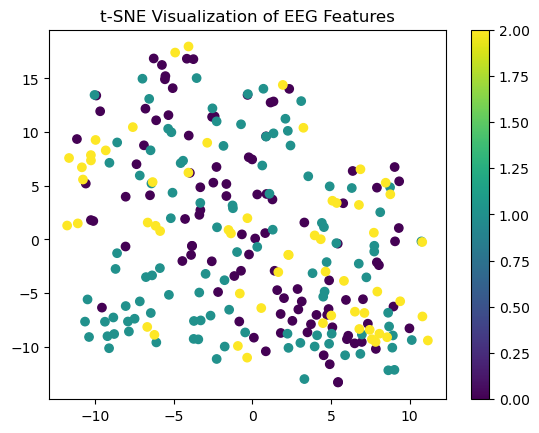

In [92]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='viridis')
plt.title("t-SNE Visualization of EEG Features")
plt.colorbar()
plt.show()

### RESEARCH MODEL USED

In [93]:
from lightgbm import LGBMClassifier
pca = PCA(n_components=90)  # Adjust based on variance
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)
lgbm = LGBMClassifier(random_state=42,max_depth=5,n_estimators=100,learning_rate=0.1)
lgbm.fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5639
[LightGBM] [Info] Number of data points in the train set: 183, number of used features: 90
[LightGBM] [Info] Start training from score -0.960991
[LightGBM] [Info] Start training from score -0.919027
[LightGBM] [Info] Start training from score -1.520607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [94]:
print("📘 LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))

📘 LightGBM Accuracy: 0.7341772151898734
              precision    recall  f1-score   support

           0       0.74      0.77      0.75        30
           1       0.73      0.71      0.72        31
           2       0.72      0.72      0.72        18

    accuracy                           0.73        79
   macro avg       0.73      0.73      0.73        79
weighted avg       0.73      0.73      0.73        79



In [95]:
from sklearn.svm import SVC
pca = PCA(n_components=90)  # Adjust based on variance
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)
svm = SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

print("📗 SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

📗 SVM Accuracy: 0.7468354430379747
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        30
           1       0.75      0.77      0.76        31
           2       0.78      0.78      0.78        18

    accuracy                           0.75        79
   macro avg       0.75      0.75      0.75        79
weighted avg       0.75      0.75      0.75        79



In [96]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7,metric='manhattan',weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("📙 kNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


📙 kNN Accuracy: 0.569620253164557
              precision    recall  f1-score   support

           0       0.51      0.73      0.60        30
           1       0.73      0.52      0.60        31
           2       0.50      0.39      0.44        18

    accuracy                           0.57        79
   macro avg       0.58      0.55      0.55        79
weighted avg       0.59      0.57      0.57        79

